<a href="https://colab.research.google.com/github/MariaIsabelLL/FunctionalAndNotFunctionalClassification/blob/main/Transformer_Bert_BETO_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Configuraciones y librerias

In [ ]:
!pip install transformers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Specifying CUDA as the device for Torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()
#torch.cuda.get_device_name(0)

In [2]:
#https://github.com/PacktPublishing/Transformers-for-Natural-Language-Processing/blob/main/Chapter02/BERT_Fine_Tuning_Sentence_Classification_DR.ipynb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
from datetime import datetime
from tqdm import tqdm, trange
from transformers import BertTokenizer, TFBertModel, Trainer
from transformers import BertForSequenceClassification, TrainingArguments
from transformers import AdamW, BertModel, BertConfig, get_linear_schedule_with_warmup
configuration = BertConfig().from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Initializing a model from the bert-base-uncased style configuration
#https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bertmodel
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

# Activating the BERT Tokenizer
#https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased
tokenizer_spanish = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', do_lower_case=False)
print(tokenizer_spanish)

#Loading the Hugging Face Bert Uncased Base Model 
#model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=2)
#model.cuda()

#https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a
#######################################
### --------- Setup BERT ---------- #### Name of the BERT model to use
#model_name = 'bert-base-uncased'# Max length of tokens
#max_length = 100# Load transformers config and set output_hidden_states to False
#config = BertConfig.from_pretrained(model_name)
#config.output_hidden_states = False# Load BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)# Load the Transformers BERT model
#transformer_model = TFBertModel.from_pretrained(model_name, config = config)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def pack_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')

def unpack_model(model_name=''): 
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

def guardar_modelo(model,nombre):
    model_json = model.to_json()
    with open(nombre+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(nombre+".h5")
        
def cargar_modelo(nombre): 
    json_file = open(nombre+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(nombre+".h5")
    loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])
    return loaded_model

def cargar_modelo_drive(nombre): 
    ruta = 'drive/MyDrive/DOCTORADO UDC/Pesquisa/Parte1/'
    json_file = open(ruta+nombre+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(ruta+nombre+".h5")
    loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])
    return loaded_model

def get_text(texto):
    new_texto = []
    #print(texto) #[ 0.49525   -0.3098045]
    #print(texto[0]) #[ 0.49525   -0.3098045]
    #print(texto[1]) #[ 0.49525   -0.3098045]
    if (texto[0] > texto[1]):
      new_texto[0] = 1
      new_texto[1] = 0
    else:
      new_texto[0] = 0
      new_texto[1] = 1
    return new_texto

def get_text_old(texto):
    #print(texto) #[ 0.49525   -0.3098045]
    #if (texto > 0.5):
    #if (texto[0] > texto[1]):
    if (texto[1] > texto[2]):
      return 1 #F
    else:
      return 2 #NF

def get_text2(texto):
    #print(texto) #[ 0.49525   -0.3098045]
    #if (texto[0] == 1):
    if (texto[1] == 1):
      return 1
    else:
      return 2

def get_text_categorical_NF(texto):
    #label_dict_F_NF_BETO = {'A': 1, 'SC': 2, 'LF': 3, 'PE': 4, 'O': 5, 'SE': 6, 'US': 7}
    #print(texto) #[ 0.49525   -0.3098045]
    for i in range(1,8):
      if (texto[i] == 1):
        return i
    
def get_text_prediccion_NF(texto):
    #print(texto)
    max_value = max(texto)
    #print(max_value)
    #index = texto.index(max_value)
    maximum = np.max(texto)
    #print(maximum)
    index_of_maximum = np.where(texto == maximum)
    #print(index_of_maximum)
    index_of_maximum2 = np.argmax(texto)
    #print(index_of_maximum2)
    return index_of_maximum2

def genera_archivo_txt(lista,nombre):
    fecha = datetime.today().strftime('%Y-%m-%d')
    news_df=pd.DataFrame(lista)
    nombreArchivo = nombre + '_' + fecha +".csv"
    news_df.to_csv(nombreArchivo, encoding='utf-8')

def get_key(val,label_dict):
    for key, value in label_dict.items():
        if val == value:
            return key


Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='dccuchile/bert-base-spanish-wwm-cased', vocab_size=31002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


#BETO F/NF

Tokenize the first sentence:
['[CLS]', 'La', 'aplicación', 'debe', 'protegerse', 'ante', 'los', 'principales', 'ataques', 'contra', 'aplicaciones', 'w', '##eb', '[SEP]']
350
39
350
39


Downloading:   0%|          | 0.00/512M [00:00<?, ?B/s]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

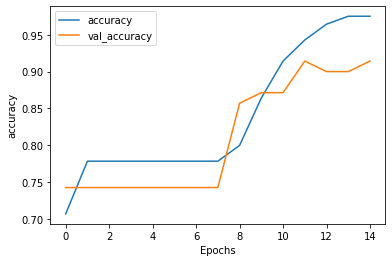

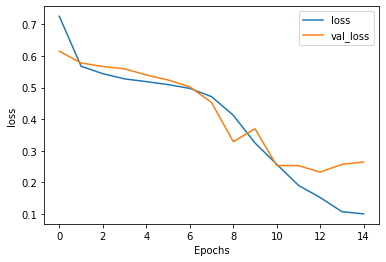

39
2/2 [==============================] - 1s 155ms/step - loss: 0.1918 - accuracy: 0.9487
LOSS, ACCURACY
[0.19180874526500702, 0.9487179517745972]
Accuracy: 0.948718
{'1': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 30}, '2': {'precision': 1.0, 'recall': 0.7777777777777778, 'f1-score': 0.8750000000000001, 'support': 9}, 'accuracy': 0.9487179487179487, 'macro avg': {'precision': 0.96875, 'recall': 0.8888888888888888, 'f1-score': 0.9213709677419355, 'support': 39}, 'weighted avg': {'precision': 0.9519230769230769, 'recall': 0.9487179487179487, 'f1-score': 0.9463399503722084, 'support': 39}}
F precision: 0.94
F recall: 1.0
F F-measure: 0.97
NF precision: 1.0
NF recall: 0.78
NF F-measure: 0.88


In [4]:
def BETO2(documento,test_size,dropout,learning_rate,epochs):
    vocab_size = 10000
    max_length = 120
    trunc_type='post'
    oov_tok = "<OOV>"  
    model_name = 'dccuchile/bert-base-spanish-wwm-cased'
    #label_dict_F_NF_BETO = {'F': 1, 'NF': 0}
    label_dict_F_NF_BETO = {'F': 1, 'NF': 2}

    dataframe = pd.read_csv(documento,sep=',')
    dataframe.loc[dataframe.ETIQUETAFINAL != 'F','ETIQUETAFINAL']=2
    dataframe.loc[dataframe.ETIQUETAFINAL == 'F','ETIQUETAFINAL']=1
    dataframe2 = dataframe.sample(frac=1)    
    X = dataframe2['REQUISITO'].values
    y = dataframe2['ETIQUETAFINAL'].values
    y=np.vstack(y).astype(np.float)
    labels = y

    # Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in X]
    tokenized_texts = [tokenizer_spanish.tokenize(sent) for sent in sentences]
    print("Tokenize the first sentence:")
    print(tokenized_texts[0])

    #Data de entrenamiento y prueba    
    #train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(X, labels, 
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sentences, labels, 
                                                                random_state=2018, test_size=0.1)
    print(len(train_inputs))
    print(len(validation_inputs))
    print(len(train_labels))
    print(len(validation_labels))
    
    y_train = to_categorical(train_labels)# Tokenize the input (takes some time)
    x_train = tokenizer_spanish(
        text=train_inputs,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)

    #https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a
    #https://www.tensorflow.org/text/tutorials/classify_text_with_bert
    #http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
    ### ------- Build the model ------- #### TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model# Load the MainLayer
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    inputs = {'input_ids': input_ids}# Load the Transformers BERT model as a layer in a Keras model
    transformer_model = TFBertModel.from_pretrained(model_name, config = configuration)
    bert = transformer_model.layers[0]# Build your model input
    bert_model = bert(inputs)[1]
    dropout = Dropout(dropout, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)# Then build your model output
    #tipo = Dense(units=2, kernel_initializer=TruncatedNormal(stddev=configuration.initializer_range), name='tipo')(pooled_output)
    tipo = Dense(units=3, kernel_initializer=TruncatedNormal(stddev=configuration.initializer_range), name='tipo')(pooled_output)
    model = Model(inputs=inputs, outputs=tipo, name='BETO_F_NF')
    model.summary()

    ### ------- Train the model ------- #### Set an optimizer
    optimizer = Adam(
        learning_rate=learning_rate,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)# Set loss and metrics
    loss = {'tipo': CategoricalCrossentropy(from_logits = True)}
    model.compile(
       optimizer = optimizer,
        loss = loss, 
        metrics = ['accuracy'])# Ready output data for the model

    history = model.fit(
        x={'input_ids': x_train['input_ids']},
        y={'tipo': y_train},
        validation_split=0.2,
        verbose=2,
        #batch_size=64,
        batch_size=32,
        epochs=epochs)    
    
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

    ### ----- Evaluate the model ------ #### Ready test data
    test_y = to_categorical(validation_labels)
    print(len(test_y))
    test_x = tokenizer_spanish(
        #text=validation_inputs.tolist(),
        text=validation_inputs,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)
    
    model_eval = model.evaluate(
        x={'input_ids': test_x['input_ids']},
        y={'tipo': test_y}    
        )
    print('LOSS, ACCURACY')
    print(model_eval)

    testing_pred = model.predict(test_x['input_ids'], verbose=0)
    #print('testing_pred',testing_pred)
    #testing_pred_final  = [get_key(get_text_old(x),label_dict_F_NF_BETO) for x in testing_pred]
    testing_pred_final  = [get_text_old(x) for x in testing_pred]
    test_y_final = [get_text2(x) for x in test_y]
    #test_y_final = validation_labels

    #get_key(get_text_old(predicted_category_F_NF_BETO[0]),label_dict_F_NF_BETO)
    #print(test_y)
    #print(test_y_final)
    #print(testing_pred)
    #print(testing_pred_final)
    accuracy = accuracy_score(test_y_final, testing_pred_final)
    print('Accuracy: %f' % accuracy)

    cr = classification_report(test_y_final, testing_pred_final, output_dict=True)
    print(cr)
    print('F precision:', round(cr['1']['precision'], 2))
    print('F recall:', round(cr['1']['recall'], 2))
    print('F F-measure:', round(cr['1']['f1-score'], 2))
    print('NF precision:', round(cr['2']['precision'], 2))
    print('NF recall:', round(cr['2']['recall'], 2))
    print('NF F-measure:', round(cr['2']['f1-score'], 2))

    guardar_modelo(model,'Modelo_Convolucional_F_NF_BETO2_GRUPO3')
    #guardar_modelo(model,'Modelo_Convolucional_F_NF_BETO2_GRUPO2')

#documento = r"datos_formal_promise.csv"
#documento = r"datos_formal_pruebas_grupo2.csv"
documento = r"datos_formal_pruebas_grupo3.csv"
#learning_rate=0.05,
#learning_rate=0.01,
#learning_rate=0.005,
#learning_rate=0.001,
#learning_rate=0.0005,
#learning_rate=0.0001,
#learning_rate=5e-05,  #accuracy 0.46
#learning_rate=1e-05, #accuracy 0.6
#learning_rate=1e-06, #accuracy 0.6
BETO2(documento,0.2,0.2,1e-05,15) #testsize 0.2 dropout 0.2, learning_rate 1e-05 epochs 15

In [ ]:
def proceso_clasificacion(documento):
  lista_clas_beto_f_nf = []
  label_dict_F_NF_BETO = {'F': 1, 'NF': 2}
  #Obtenemos el modelo BETO ya entrenado
  model_F_NF_BETO = cargar_modelo_drive('Modelo_Convolucional_F_NF_BETO2')  
  #model_F_NF_BETO = cargar_modelo('Modelo_Convolucional_F_NF_BETO2')  
  vocab_size = 10000
  max_length = 120
  trunc_type='post'
  oov_tok = "<OOV>"  
  model_name = 'dccuchile/bert-base-spanish-wwm-cased'
  tokenizer_spanish = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
       
  df = pd.read_csv(documento)
  #df.loc[df.TIPO != 'F','TIPO']='NF'
  df.loc[df.ETIQUETAFINAL != 'F','ETIQUETAFINAL']='NF'

  for text in df['REQUISITO']:
    test_x = tokenizer_spanish(
            text=text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length', 
            return_tensors='tf',
            return_token_type_ids = False,
            return_attention_mask = False,
            verbose = True)
    predicted_category_F_NF_BETO = model_F_NF_BETO.predict(test_x['input_ids'], verbose=0)
    print('Predicción Clase BETO F_NF',predicted_category_F_NF_BETO)
    #print('Predicción Clase BETO F_NF',get_text_old(predicted_category_F_NF_BETO[0]))
    print('Predicción Clase BETO F_NF',get_key(get_text_old(predicted_category_F_NF_BETO[0]),label_dict_F_NF_BETO))
    lista_clas_beto_f_nf.append(get_key(get_text_old(predicted_category_F_NF_BETO[0]),label_dict_F_NF_BETO))

  df['BETO'] = lista_clas_beto_f_nf
  #X1 = df['TIPO'].values
  X1 = df['ETIQUETAFINAL'].values
  #print(X1)
  clas_cnn_f_nf_beto=df['BETO'].values
  
  accuracy = accuracy_score(X1, clas_cnn_f_nf_beto)
  print('Accuracy: %f' % accuracy)
  precision = precision_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='F')
  recall = recall_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='F')
  f1 = f1_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='F')
  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  precision = precision_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='NF')
  recall = recall_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='NF')
  f1 = f1_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='NF')
  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  #cm = confusion_matrix(X1, N)
  #print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9)) 
  
  cr = classification_report(X1, clas_cnn_f_nf_beto, output_dict=True)
  print('F precision:', round(cr['F']['precision'], 2))
  print('F recall:', round(cr['F']['recall'], 2))
  print('F F-measure:', round(cr['F']['f1-score'], 2))
  print('NF precision:', round(cr['NF']['precision'], 2))
  print('NF recall:', round(cr['NF']['recall'], 2))
  print('NF F-measure:', round(cr['NF']['f1-score'], 2))

  genera_archivo_txt(df,'Lista_requisitos_clasificacion')
     
proceso_clasificacion('datos_formal_pruebas_grupo3.csv')
#proceso_clasificacion('datos_formal_pruebas_grupo2.csv')
#proceso_clasificacion('datos_formal_pruebas.csv')

Predicción Clase BETO F_NF [[-1.5182464 -1.4070355  3.0619578]]
Predicción Clase BETO F_NF NF
Predicción Clase BETO F_NF [[-1.921528  -0.599339   2.9306417]]
Predicción Clase BETO F_NF NF
Predicción Clase BETO F_NF [[-1.7616802 -1.2543285  3.1676047]]
Predicción Clase BETO F_NF NF
Predicción Clase BETO F_NF [[-2.9327705  1.4586428  1.4188191]]
Predicción Clase BETO F_NF F
Predicción Clase BETO F_NF [[-2.654404   0.1330625  2.6514266]]
Predicción Clase BETO F_NF NF
Predicción Clase BETO F_NF [[-1.8698579  2.9614735 -1.3806255]]
Predicción Clase BETO F_NF F
Predicción Clase BETO F_NF [[-2.4493823  -0.05783242  2.8811011 ]]
Predicción Clase BETO F_NF NF
Predicción Clase BETO F_NF [[-2.599218    2.7374115  -0.23241106]]
Predicción Clase BETO F_NF F
Predicción Clase BETO F_NF [[-2.6466897   2.416306    0.07831549]]
Predicción Clase BETO F_NF F
Predicción Clase BETO F_NF [[-1.8794817  -0.42342788  2.985976  ]]
Predicción Clase BETO F_NF NF
Predicción Clase BETO F_NF [[-1.969989  -0.6667401  

#BETO K-FOLD F/NF

In [6]:
def beto_kfold(documento,kfold,dropout,learning_rate,epochs):
    accuracy_list=[]
    f_precision=[]
    f_recall=[]
    f_f_score=[]
    fn_precision=[]
    fn_recall=[]
    fn_f_score=[]

    vocab_size = 10000
    max_length = 120
    trunc_type='post'
    oov_tok = "<OOV>"  
    model_name = 'dccuchile/bert-base-spanish-wwm-cased'
     
    dataframe = pd.read_csv(documento,sep=',')
    dataframe.loc[dataframe.ETIQUETAFINAL != 'F','ETIQUETAFINAL']=2
    dataframe.loc[dataframe.ETIQUETAFINAL == 'F','ETIQUETAFINAL']=1
    dataframe2 = dataframe.sample(frac=1)    
    X = dataframe2['REQUISITO'].values
    y = dataframe2['ETIQUETAFINAL'].values
    y=np.vstack(y).astype(np.float)
    
    n_folds = kfold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for train, test in kf.split(X):  
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        y_train_tok = to_categorical(y_train)# Tokenize the input (takes some time)
        X_train_tok = tokenizer_spanish(
          text=X_train.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding='max_length', 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
    
        ### ------- Build the model ------- #### TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model# Load the MainLayer
        input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
        inputs = {'input_ids': input_ids}# Load the Transformers BERT model as a layer in a Keras model
        transformer_model = TFBertModel.from_pretrained(model_name, config = configuration)
        bert = transformer_model.layers[0]# Build your model input
        bert_model = bert(inputs)[1]
        dropout = Dropout(dropout, name='pooled_output')
        pooled_output = dropout(bert_model, training=False)# Then build your model output
        tipo = Dense(units=3, kernel_initializer=TruncatedNormal(stddev=configuration.initializer_range), name='tipo')(pooled_output)
        model = Model(inputs=inputs, outputs=tipo, name='BETO_F_NF')
        model.summary()

        ### ------- Train the model ------- #### Set an optimizer
        optimizer = Adam(
            learning_rate=learning_rate,
            epsilon=1e-08,
            decay=0.01,
            clipnorm=1.0)# Set loss and metrics
        loss = {'tipo': CategoricalCrossentropy(from_logits = True)}
        model.compile(
          optimizer = optimizer,
            loss = loss, 
            metrics = ['accuracy'])# Ready output data for the model

        history = model.fit(
            x={'input_ids': X_train_tok['input_ids']},
            y={'tipo': y_train_tok},
            validation_split=0.2,
            verbose=2,
            #batch_size=64,
            batch_size=32,
            epochs=epochs)  

        ### ----- Evaluate the model ------ #### Ready test data
        test_y = to_categorical(y_test)
        print(len(test_y))
        test_x = tokenizer_spanish(
            text=X_test.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length', 
            return_tensors='tf',
            return_token_type_ids = False,
            return_attention_mask = False,
            verbose = True)

        model_eval = model.evaluate(
            x={'input_ids': test_x['input_ids']},
            y={'tipo': test_y}    
            )
        print('LOSS, ACCURACY')
        print(model_eval)

        testing_pred = model.predict(test_x['input_ids'], verbose=0)
        testing_pred_final  = [get_text_old(x) for x in testing_pred]
        test_y_final = [get_text2(x) for x in test_y]
        
        accuracy = accuracy_score(test_y_final, testing_pred_final)
        print('Accuracy: %f' % accuracy)
        accuracy_list.append(accuracy)

        cr = classification_report(test_y_final, testing_pred_final, output_dict=True)
        f_precision.append(round(cr['1']['precision'], 2))
        f_recall.append(round(cr['1']['recall'], 2))
        f_f_score.append(round(cr['1']['f1-score'], 2))
        fn_precision.append(round(cr['2']['precision'], 2))
        fn_recall.append(round(cr['2']['recall'], 2))
        fn_f_score.append(round(cr['2']['f1-score'], 2))

    print(np.mean(accuracy_list))   
    print(np.mean(f_precision))   
    print(np.mean(f_recall))   
    print(np.mean(f_f_score))  
    print(np.mean(fn_precision))   
    print(np.mean(fn_recall))   
    print(np.mean(fn_f_score))  

#documento = r"datos_formal_promise.csv"
#documento = r"datos_formal_pruebas_grupo2.csv"
documento = r"datos_formal_pruebas_grupo3.csv"
beto_kfold(documento,10,0.2,1e-05,15) #kfold 5 dropout 0.2, learning_rate 1e-05 epochs 15


Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

#BETO NF

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


329
296
33
296
33


Downloading:   0%|          | 0.00/512M [00:00<?, ?B/s]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

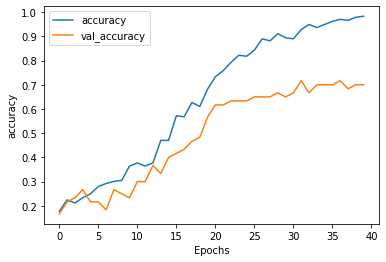

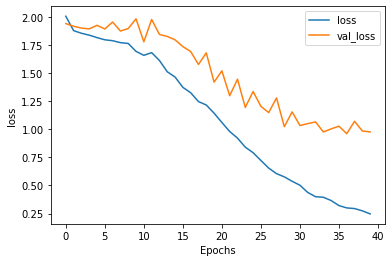

33
2/2 [==============================] - 11s 460ms/step - loss: 0.7612 - accuracy: 0.8182
LOSS, ACCURACY
[0.7612490653991699, 0.8181818127632141]
testing_pred [[-0.89636993 -1.1250228  -0.4181116  -1.0619364  -0.47358713 -0.12876625
   3.9103253  -0.569445  ]
 [-1.1064091  -1.0909698   0.22626813  0.49330586 -0.58208036  2.2551723
  -1.1547285   1.1213965 ]
 [-1.065922   -1.0379456   0.4611481  -0.4567877   1.7185835   0.60388213
  -0.46904594  0.08214572]
 [-1.0499547   0.3566841  -0.73538613  1.0634991  -1.1788671   3.184169
  -0.77890056 -0.7243231 ]
 [-0.919418   -1.3210841  -0.12581028 -1.2863401  -0.39706764 -0.03096374
   3.7339494  -0.30054554]
 [-0.8536542   2.0172246  -0.9572818   0.13234346  0.7307439   1.6666167
  -1.4593067  -1.4455595 ]
 [-1.1812193  -0.8887951   0.11737736 -0.6378225  -0.33887127  3.19937
  -0.06853009 -0.6820888 ]
 [-0.72918516  0.16599807 -0.99277884  3.5369816  -0.7745279   0.57728934
  -1.267594   -0.28192782]
 [-0.7939784  -1.0321534  -0.4652793  -

In [ ]:
def BETO2_NF(documento,test_size):
    vocab_size = 10000
    max_length = 120
    trunc_type='post'
    oov_tok = "<OOV>"  
    model_name = 'dccuchile/bert-base-spanish-wwm-cased'
    label_dict_NF_BETO = {'A': 1, 'SC': 2, 'LF': 3, 'PE': 4, 'O': 5, 'SE': 6, 'US': 7}

    dataframe = pd.read_csv(documento,sep=',')
    dataframe2 = dataframe[dataframe.TIPO.isin(['A','SC','LF','PE','O','SE','US'])]
    dataframe2.loc[dataframe.TIPO == 'A','TIPO']=1
    dataframe2.loc[dataframe.TIPO == 'SC','TIPO']=2
    dataframe2.loc[dataframe.TIPO == 'LF','TIPO']=3
    dataframe2.loc[dataframe.TIPO == 'PE','TIPO']=4
    dataframe2.loc[dataframe.TIPO == 'O','TIPO']=5
    dataframe2.loc[dataframe.TIPO == 'SE','TIPO']=6
    dataframe2.loc[dataframe.TIPO == 'US','TIPO']=7
    #dataframe3 = dataframe2.sample(frac=1)    
    dataframe3 = dataframe2  
    
    X = dataframe3['REQUISITO'].values
    y = dataframe3['TIPO'].values
    y=np.vstack(y).astype(np.float)
    labels = y
    print(len(X)) #329

    # Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in X]

    #Data de entrenamiento y prueba    
    #train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(X, labels, 
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sentences, labels, 
                                                                random_state=2018, test_size=0.1)
    print(len(train_inputs))
    print(len(validation_inputs))
    print(len(train_labels))
    print(len(validation_labels))
    
    y_train = to_categorical(train_labels)# Tokenize the input (takes some time)
    x_train = tokenizer_spanish(
        text=train_inputs,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)

    #https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a
    #https://www.tensorflow.org/text/tutorials/classify_text_with_bert
    #http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
    ### ------- Build the model ------- #### TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model# Load the MainLayer
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    inputs = {'input_ids': input_ids}# Load the Transformers BERT model as a layer in a Keras model
    transformer_model = TFBertModel.from_pretrained(model_name, config = configuration)
    bert = transformer_model.layers[0]# Build your model input
    bert_model = bert(inputs)[1]
    #dropout = Dropout(0.2, name='pooled_output')
    dropout = Dropout(0.3, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)# Then build your model output
    tipo = Dense(units=8, kernel_initializer=TruncatedNormal(stddev=configuration.initializer_range), name='tipo')(pooled_output)
    model = Model(inputs=inputs, outputs=tipo, name='BETO_F_NF')
    model.summary()

    ### ------- Train the model ------- #### Set an optimizer
    optimizer = Adam(
        #learning_rate=0.05,
        #learning_rate=0.01,
        #learning_rate=0.005,
        #learning_rate=0.001,
        #learning_rate=0.0005,
        #learning_rate=0.0001,
        #learning_rate=5e-05,  #accuracy  0.81
        learning_rate=1e-05, #accuracy 
        #learning_rate=1e-06, #accuracy 
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)# Set loss and metrics
    loss = {'tipo': CategoricalCrossentropy(from_logits = True)}
    model.compile(
       optimizer = optimizer,
        loss = loss, 
        metrics = ['accuracy'])# Ready output data for the model

    history = model.fit(
        x={'input_ids': x_train['input_ids']},
        y={'tipo': y_train},
        validation_split=0.2,
        verbose=2,
        batch_size=32,
        epochs=40)    
    
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

    ### ----- Evaluate the model ------ #### Ready test data
    test_y = to_categorical(validation_labels)
    print(len(test_y))
    test_x = tokenizer_spanish(
        text=validation_inputs,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)
    
    model_eval = model.evaluate(
        x={'input_ids': test_x['input_ids']},
        y={'tipo': test_y}    
        )
    print('LOSS, ACCURACY')
    print(model_eval)

    #print(test_y)
    
    testing_pred = model.predict(test_x['input_ids'], verbose=0)
    print('testing_pred',testing_pred)
    testing_pred_final  = [get_text_prediccion_NF(x) for x in testing_pred]
    test_y_final = [get_text_categorical_NF(x) for x in test_y]
    
    #print(test_y_final)
    #print(testing_pred_final)
    accuracy = accuracy_score(test_y_final, testing_pred_final)
    print('Accuracy: %f' % accuracy)

    cr = classification_report(test_y_final, testing_pred_final, output_dict=True)
    print(cr)
    #for i in label_dict_NF_BETO:
    for i in range(1,8):
      if str(i) in cr:
          print(str(i)+' precision:', round(cr[str(i)]['precision'], 2))
          print(str(i)+' recall:', round(cr[str(i)]['recall'], 2))
          print(str(i)+' F-measure:', round(cr[str(i)]['f1-score'], 2))

    guardar_modelo(model,'Modelo_Convolucional_NF_BETO2')

documento = r"datos_formal_promise.csv"
#documento = r"datos_formal_pruebas_grupo2.csv"
BETO2_NF(documento,0.2)

In [ ]:
def proceso_clasificacion_NF(documento):
  lista_clas_beto_nf = []
  label_dict_NF_BETO = {'A': 1, 'SC': 2, 'LF': 3, 'PE': 4, 'O': 5, 'SE': 6, 'US': 7}
  #Obtenemos el modelo BETO ya entrenado
  model_NF_BETO = cargar_modelo_drive('Modelo_Convolucional_NF_BETO2')  
  #model_NF_BETO = cargar_modelo('Modelo_Convolucional_NF_BETO2')  
  vocab_size = 10000
  max_length = 120
  trunc_type='post'
  oov_tok = "<OOV>"  
  model_name = 'dccuchile/bert-base-spanish-wwm-cased'
  tokenizer_spanish = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
       
  df = pd.read_csv(documento)
  df.loc[df.TIPO != 'F','TIPO']='NF'
  dataframe2 = df[dataframe.TIPO.isin(['A','SC','LF','PE','O','SE','US'])]
  dataframe2.loc[dataframe.TIPO == 'A','TIPO']=1
  dataframe2.loc[dataframe.TIPO == 'SC','TIPO']=2
  dataframe2.loc[dataframe.TIPO == 'LF','TIPO']=3
  dataframe2.loc[dataframe.TIPO == 'PE','TIPO']=4
  dataframe2.loc[dataframe.TIPO == 'O','TIPO']=5
  dataframe2.loc[dataframe.TIPO == 'SE','TIPO']=6
  dataframe2.loc[dataframe.TIPO == 'US','TIPO']=7
  #dataframe3 = dataframe2.sample(frac=1)    
  dataframe3 = dataframe2  

  for text in dataframe3['REQUISITO']:
    test_x = tokenizer_spanish(
            text=text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length', 
            return_tensors='tf',
            return_token_type_ids = False,
            return_attention_mask = False,
            verbose = True)
    predicted_category_NF_BETO = model_NF_BETO.predict(test_x['input_ids'], verbose=0)
    print('Predicción Clase BETO NF',predicted_category_NF_BETO)
    print('Predicción Clase BETO F_NF',get_key(get_text_prediccion_NF(predicted_category_NF_BETO[0]),label_dict_NF_BETO))
    lista_clas_beto_nf.append(get_key(get_text_prediccion_NF(predicted_category_NF_BETO[0]),label_dict_NF_BETO))

  df['BETO'] = lista_clas_beto_nf
  X1 = df['TIPO'].values
  #print(X1)
  clas_cnn_f_nf_beto=df['BETO'].values
  
  accuracy = accuracy_score(X1, clas_cnn_f_nf_beto)
  print('Accuracy: %f' % accuracy)
  precision = precision_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='F')
  recall = recall_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='F')
  f1 = f1_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='F')
  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  precision = precision_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='NF')
  recall = recall_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='NF')
  f1 = f1_score(X1, clas_cnn_f_nf_beto, average="binary", pos_label='NF')
  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  #cm = confusion_matrix(X1, N)
  #print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9)) 
  
  cr = classification_report(X1, clas_cnn_f_nf_beto, output_dict=True)
  print('F precision:', round(cr['F']['precision'], 2))
  print('F recall:', round(cr['F']['recall'], 2))
  print('F F-measure:', round(cr['F']['f1-score'], 2))
  print('NF precision:', round(cr['NF']['precision'], 2))
  print('NF recall:', round(cr['NF']['recall'], 2))
  print('NF F-measure:', round(cr['NF']['f1-score'], 2))

  genera_archivo_txt(df,'Lista_requisitos_clasificacion')
     
proceso_clasificacion_NF('datos_formal_pruebas.csv')


#BETO K-FOLD NF

In [ ]:
def beto_kfold_NF(documento,kfold):
    accuracy_list=[]
    a_precision=[]
    a_recall=[]
    a_f_score=[]
    lf_precision=[]
    lf_recall=[]
    lf_f_score=[]
    o_precision=[]
    o_recall=[]
    o_f_score=[]
    pe_precision=[]
    pe_recall=[]
    pe_f_score=[]
    sc_precision=[]
    sc_recall=[]
    sc_f_score=[]
    se_precision=[]
    se_recall=[]
    se_f_score=[]
    us_precision=[]
    us_recall=[]
    us_f_score=[]

    vocab_size = 10000
    max_length = 120
    trunc_type='post'
    oov_tok = "<OOV>"  
    model_name = 'dccuchile/bert-base-spanish-wwm-cased'
     
    label_dict_NF_BETO = {'A': 1, 'SC': 2, 'LF': 3, 'PE': 4, 'O': 5, 'SE': 6, 'US': 7}

    dataframe = pd.read_csv(documento,sep=',')
    dataframe2 = dataframe[dataframe.TIPO.isin(['A','SC','LF','PE','O','SE','US'])]
    dataframe2.loc[dataframe.TIPO == 'A','TIPO']=1
    dataframe2.loc[dataframe.TIPO == 'SC','TIPO']=2
    dataframe2.loc[dataframe.TIPO == 'LF','TIPO']=3
    dataframe2.loc[dataframe.TIPO == 'PE','TIPO']=4
    dataframe2.loc[dataframe.TIPO == 'O','TIPO']=5
    dataframe2.loc[dataframe.TIPO == 'SE','TIPO']=6
    dataframe2.loc[dataframe.TIPO == 'US','TIPO']=7
    #dataframe3 = dataframe2.sample(frac=1)    
    dataframe3 = dataframe2  

    X = dataframe3['REQUISITO'].values
    y = dataframe3['TIPO'].values
    y=np.vstack(y).astype(np.float)
    #labels = y
    
    n_folds = kfold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for train, test in kf.split(X):  
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        y_train_tok = to_categorical(y_train)# Tokenize the input (takes some time)
        X_train_tok = tokenizer_spanish(
          text=X_train.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding='max_length', 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
    
        ### ------- Build the model ------- #### TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model# Load the MainLayer
        input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
        inputs = {'input_ids': input_ids}# Load the Transformers BERT model as a layer in a Keras model
        transformer_model = TFBertModel.from_pretrained(model_name, config = configuration)
        bert = transformer_model.layers[0]# Build your model input
        bert_model = bert(inputs)[1]
        dropout = Dropout(0.3, name='pooled_output')
        pooled_output = dropout(bert_model, training=False)# Then build your model output
        tipo = Dense(units=8, kernel_initializer=TruncatedNormal(stddev=configuration.initializer_range), name='tipo')(pooled_output)
        model = Model(inputs=inputs, outputs=tipo, name='BETO_F_NF')
        model.summary()

        ### ------- Train the model ------- #### Set an optimizer
        optimizer = Adam(
            #learning_rate=5e-05,
            learning_rate=1e-05,
            epsilon=1e-08,
            decay=0.01,
            clipnorm=1.0)# Set loss and metrics
        loss = {'tipo': CategoricalCrossentropy(from_logits = True)}
        model.compile(
          optimizer = optimizer,
            loss = loss, 
            metrics = ['accuracy'])# Ready output data for the model

        history = model.fit(
            x={'input_ids': X_train_tok['input_ids']},
            y={'tipo': y_train_tok},
            validation_split=0.2,
            verbose=2,
            batch_size=32,
            #epochs=15)  
            epochs=40)   

        ### ----- Evaluate the model ------ #### Ready test data
        test_y = to_categorical(y_test)
        print(len(test_y))
        test_x = tokenizer_spanish(
            text=X_test.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length', 
            return_tensors='tf',
            return_token_type_ids = False,
            return_attention_mask = False,
            verbose = True)

        model_eval = model.evaluate(
            x={'input_ids': test_x['input_ids']},
            y={'tipo': test_y}    
            )
        print('LOSS, ACCURACY')
        print(model_eval)

        testing_pred = model.predict(test_x['input_ids'], verbose=0)
        print('testing_pred',testing_pred)
        testing_pred_final  = [get_text_prediccion_NF(x) for x in testing_pred]
        test_y_final = [get_text_categorical_NF(x) for x in test_y]
    
        #print(test_y_final)
        #print(testing_pred_final)
        accuracy = accuracy_score(test_y_final, testing_pred_final)
        print('Accuracy: %f' % accuracy)
        accuracy_list.append(accuracy)

        cr = classification_report(test_y_final, testing_pred_final, output_dict=True)
        print(cr)
        for i in range(1,8):
            if str(i) == '1': #'A'
                a_precision.append(round(cr[str(i)]['precision'], 2))
                a_recall.append(round(cr[str(i)]['recall'], 2))
                a_f_score.append(round(cr[str(i)]['f1-score'], 2))
            if str(i) == '3': #'LF':
                lf_precision.append(round(cr[str(i)]['precision'], 2))
                lf_recall.append(round(cr[str(i)]['recall'], 2))
                lf_f_score.append(round(cr[str(i)]['f1-score'], 2))
            if str(i) == '5': #'O':
                o_precision.append(round(cr[str(i)]['precision'], 2))
                o_recall.append(round(cr[str(i)]['recall'], 2))
                o_f_score.append(round(cr[str(i)]['f1-score'], 2))
            if str(i) == '4': #'PE':
                pe_precision.append(round(cr[str(i)]['precision'], 2))
                pe_recall.append(round(cr[str(i)]['recall'], 2))
                pe_f_score.append(round(cr[str(i)]['f1-score'], 2))
            if str(i) == '2': #'SC':
                sc_precision.append(round(cr[str(i)]['precision'], 2))
                sc_recall.append(round(cr[str(i)]['recall'], 2))
                sc_f_score.append(round(cr[str(i)]['f1-score'], 2))
            if str(i) == '6': #'SE':
                se_precision.append(round(cr[str(i)]['precision'], 2))
                se_recall.append(round(cr[str(i)]['recall'], 2))
                se_f_score.append(round(cr[str(i)]['f1-score'], 2))
            if str(i) == '7': #'US':
                us_precision.append(round(cr[str(i)]['precision'], 2))
                us_recall.append(round(cr[str(i)]['recall'], 2))
                us_f_score.append(round(cr[str(i)]['f1-score'], 2))
        
    print(np.mean(accuracy_list))   
    print(np.mean(a_precision))   
    print(np.mean(a_recall))   
    print(np.mean(a_f_score))   
    print(np.mean(lf_precision))   
    print(np.mean(lf_recall))   
    print(np.mean(lf_f_score))   
    print(np.mean(o_precision))   
    print(np.mean(o_recall))   
    print(np.mean(o_f_score))   
    print(np.mean(pe_precision))   
    print(np.mean(pe_recall))   
    print(np.mean(pe_f_score))  
    print(np.mean(sc_precision))   
    print(np.mean(sc_recall))   
    print(np.mean(sc_f_score))   
    print(np.mean(se_precision))   
    print(np.mean(se_recall))   
    print(np.mean(se_f_score))   
    print(np.mean(us_precision))   
    print(np.mean(us_recall))   
    print(np.mean(us_f_score))   

documento = r"datos_formal_promise.csv"
#documento = r"datos_formal_pruebas_grupo2.csv"
beto_kfold_NF(documento,5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel

Model: "BETO_F_NF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 120)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109850880 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             120, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                         

KeyboardInterrupt: ignored